In [1]:
import os
from cil.io import ZEISSDataReader
from cil.processors import Binner, TransmissionAbsorptionConverter, Slicer
from cil.plugins.astra import ProjectionOperator, FBP
from cil.optimisation.functions import LeastSquares, L2NormSquared
from cil.utilities.display import show2D, show_geometry
from cil.optimisation.algorithms import FISTA, ISTA
from cil.plugins.ccpi_regularisation.functions import FGP_TV
from cil.optimisation.utilities import RandomSampling, SequentialSampling
from cil.optimisation.functions import SGFunction, SAGFunction, SAGAFunction
import numpy as np


### Utility class to compute distance from the optimal solution

In [2]:
class DistanceFromOptimalSolution():

    def __init__(self, algorithm, optimal_solution):

        # get algorithm
        self.algorithm = algorithm

        # optimal solution
        self.optimal_solution = optimal_solution

        # store distance from optimal in algorithm
        self.algorithm.distance_from_optimal = []
        
    def __call__(self):
        
        diff_from_optimal = (self.algorithm.x - self.optimal_solution).norm()
        self.algorithm.distance_from_optimal.append(diff_from_optimal)
    

### Read walnut data

In [3]:
pathname = os.path.abspath("../../Hackathon-000-Stochastic-Algorithms/contrib/valnut/valnut_2014-03-21_643_28/tomo-A")   # Update this to where data set was unzipped to.


In [4]:
data_name = "valnut_tomo-A.txrm"
filename = os.path.join(pathname,data_name )

reader = ZEISSDataReader()
reader.set_up(file_name=filename)
data3D = reader.read()
data3D.reorder('astra')

### Extract central slice (2D)

In [5]:
# Extract vertical slice
data2D = data3D.get_slice(vertical='centre')

# Select every 2 angles
sliced_data = Slicer(roi={'angle':(0,1600,2)})(data2D)

# Reduce background regions
binned_data = Binner(roi={'horizontal':(120,-120,2)})(sliced_data)

# Create absorption data 
data = TransmissionAbsorptionConverter()(binned_data) 

# Remove circular artifacts
data -= np.mean(data.as_array()[80:100,0:30])

# Get Image and Acquisition geometries for one slice
ag2D = data.geometry
ag2D.set_angles(ag2D.angles, initial_angle=0.2, angle_unit='radian')
ig2D = ag2D.get_ImageGeometry()

A = ProjectionOperator(ig2D, ag2D, device = "gpu")

### FDK reconstruction

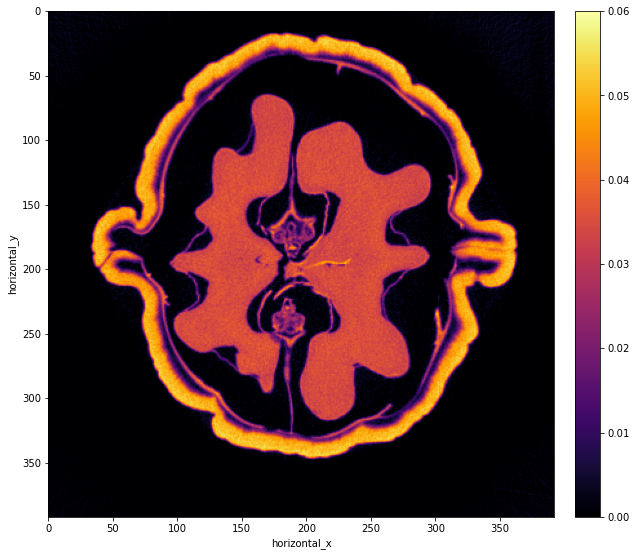

In [6]:
fbp_recon = FBP(ig2D, ag2D)(data)
show2D(fbp_recon, cmap="inferno", origin="upper", fix_range=(0,0.06))

### Compute optimal solution for the TV reconstruction problem using FISTA

In [7]:
alpha = 0.003 
G = (alpha/ig2D.voxel_size_x) * FGP_TV(max_iteration = 100, device="gpu") 

In [8]:
initial = ig2D.allocate()
F_FISTA = LeastSquares(A, b = data, c = 0.5)
step_size_fista = 1./F_FISTA.L
fista = FISTA(initial = initial, f=F_FISTA, step_size = step_size_fista, g=G, update_objective_interval = 500, 
            max_iteration = 3000)
fista.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       3000         0.000          2.88886e+04
      500       3000         0.066          2.43977e+02
     1000       3000         0.064          2.43977e+02
     1500       3000         0.063          2.43977e+02
     2000       3000         0.064          2.43977e+02
     2500       3000         0.064          2.43977e+02
     3000       3000         0.063          2.43977e+02
-------------------------------------------------------
     3000       3000         0.063          2.43977e+02
Stop criterion has been reached.



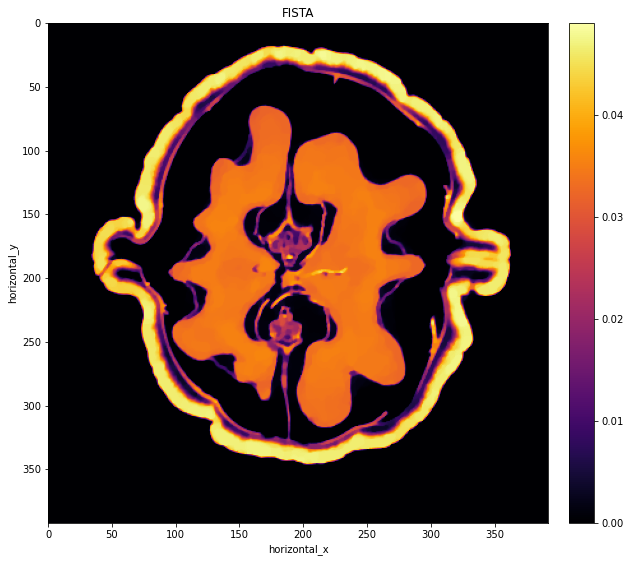

In [9]:
optimal = fista.solution
show2D(fista.solution, cmap="inferno", origin="upper", title="FISTA")

# Stochastic Framework setup

### Split acquisition data (Sequentially)

We split the acquisition data in chunks sequentially, i.e.,
- [0,3,6,...]
- [1,4,7,...]

- Note: For random splitting we can use 

```code

random_splitting = RandomSampling(len(data.geometry.angles), batch_size=batch_size, replace=False, seed=20)
list_ad_chunks = data.split_to_chunks(random_splitting)

```

### Create finite sum, where $n$ is the number of subsets


$$\sum_{i=1}^{n}f_{i}$$

In [10]:
num_subsets = 160
batch_size = int(len(data.geometry.angles)/num_subsets)
num_epochs = 50
print("Batch_size = {}".format(batch_size))

Batch_size = 5


In [11]:
sequential_splitting = SequentialSampling(len(data.geometry.angles), step_size = num_subsets, batch_size=batch_size)
list_ad_chunks = data.split_to_chunks(sequential_splitting)
print("Total number of chunks = {}".format(len(list_ad_chunks)))
print(sequential_splitting.partition_list[0:10])

Total number of chunks = 160
[[0, 160, 320, 480, 640], [1, 161, 321, 481, 641], [2, 162, 322, 482, 642], [3, 163, 323, 483, 643], [4, 164, 324, 484, 644], [5, 165, 325, 485, 645], [6, 166, 326, 486, 646], [7, 167, 327, 487, 647], [8, 168, 328, 488, 648], [9, 169, 329, 489, 649]]


### Prepare finite sum, based on the above splitting.

In [12]:
def list_of_functions(data):
    
    list_funcs = []
    ig = data[0].geometry.get_ImageGeometry()
    
    for d in data:
        ageom_subset = d.geometry        
        Ai = ProjectionOperator(ig, ageom_subset, device = 'gpu')    
        fi = LeastSquares(Ai, b = d, c = 0.5)
        list_funcs.append(fi)   
        
    return list_funcs

list_func = list_of_functions(list_ad_chunks) 

### Deterministic ISTA

In [13]:
initial = ig2D.allocate()
F_ISTA = LeastSquares(A, b = data, c = 0.5)
step_size_ista = 1./F_ISTA.L
ista = ISTA(initial = initial, f=F_ISTA, step_size = step_size_ista, g=G, update_objective_interval = 1, 
            max_iteration = num_epochs)
dist_opt_sol = DistanceFromOptimalSolution(ista, optimal)
ista.run(verbose=1, callback=dist_opt_sol)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         50         0.000          2.88886e+04
        1         50         0.058          3.47412e+03
        2         50         0.056          2.55205e+03
        3         50         0.057          1.98028e+03
        4         50         0.060          1.60853e+03
        5         50         0.062          1.36041e+03
        6         50         0.063          1.19068e+03
        7         50         0.063          1.06633e+03
        8         50         0.062          9.69226e+02
        9         50         0.061          8.90275e+02
       10         50         0.061          8.24188e+02
       11         50         0.060          7.67603e+02
       12         50         0.059          7.18360e+02
       13         50         0.059          6.75198e+02
       14         50         0.058          6.37317e+02
       15         50         0.058          6.03

In [14]:
len_func = len(list_func)
# selection = RandomSampling(len_func, replace=False, shuffle=True, seed=10)
selection = RandomSampling(len_func, replace=True, seed=10)
selection.show_epochs(3)

func_sgd = SGFunction(list_func, selection=selection)
func_sag = SAGFunction(list_func, selection=selection)
func_saga = SAGAFunction(list_func, selection=selection)
stoch_estimators = [func_sgd, func_sag, func_saga]

 Epoch : 0, indices used : [80, 27, 145, 47, 128, 103, 114, 10, 118, 101, 12, 44, 144, 29, 131, 78, 54, 56, 14, 15, 133, 113, 19, 126, 125, 7, 143, 100, 97, 39, 122, 68, 125, 126, 95, 85, 75, 2, 100, 3, 135, 62, 102, 143, 143, 37, 48, 71, 65, 23, 23, 129, 30, 61, 139, 57, 53, 41, 150, 133, 128, 69, 65, 7, 51, 128, 138, 40, 18, 29, 107, 37, 65, 86, 141, 154, 20, 45, 85, 73, 9, 98, 107, 156, 153, 152, 42, 63, 51, 59, 61, 68, 132, 17, 136, 132, 90, 142, 150, 60, 113, 116, 88, 118, 132, 70, 158, 136, 71, 156, 57, 153, 91, 69, 37, 29, 35, 125, 116, 151, 81, 82, 144, 44, 119, 145, 109, 138, 82, 78, 136, 139, 134, 62, 16, 4, 128, 15, 48, 75, 50, 43, 133, 2, 135, 31, 140, 124, 26, 29, 56, 32, 67, 145, 129, 18, 51, 59, 110, 18] 
 Epoch : 1, indices used : [8, 109, 28, 3, 155, 135, 69, 21, 53, 136, 57, 92, 29, 61, 24, 77, 122, 63, 45, 47, 39, 154, 37, 65, 121, 79, 98, 135, 84, 12, 124, 16, 102, 155, 146, 108, 118, 58, 126, 156, 22, 80, 20, 72, 54, 35, 22, 88, 48, 50, 5, 107, 72, 40, 92, 107, 17,

In [15]:
recons = [None]*len(stoch_estimators)

initial = ig2D.allocate()
step_size_ista = 0.0003

In [16]:
for i in range(len(stoch_estimators)):
    
    ista = ISTA(initial = initial, f=stoch_estimators[i], step_size = step_size_ista, g=G, 
                update_objective_interval = selection.num_batches, 
                max_iteration = num_epochs*selection.num_batches)     
    ci = DistanceFromOptimalSolution(ista, optimal)
    ista.run(verbose=1, callback=ci)
    recons[i] = ista

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       8000         0.000          2.88886e+04
      160       8000         0.022          2.55819e+02
      320       8000         0.023          2.47296e+02
      480       8000         0.023          2.46999e+02
      640       8000         0.023          2.48130e+02
      800       8000         0.023          2.45833e+02
      960       8000         0.023          2.46388e+02
     1120       8000         0.023          2.44926e+02
     1280       8000         0.023          2.46053e+02
     1440       8000         0.024          2.45579e+02
     1600       8000         0.024          2.45230e+02
     1760       8000         0.024          2.45351e+02
     1920       8000         0.024          2.47313e+02
     2080       8000         0.024          2.45681e+02
     2240       8000         0.024          2.45624e+02
     2400       8000         0.024          2.46

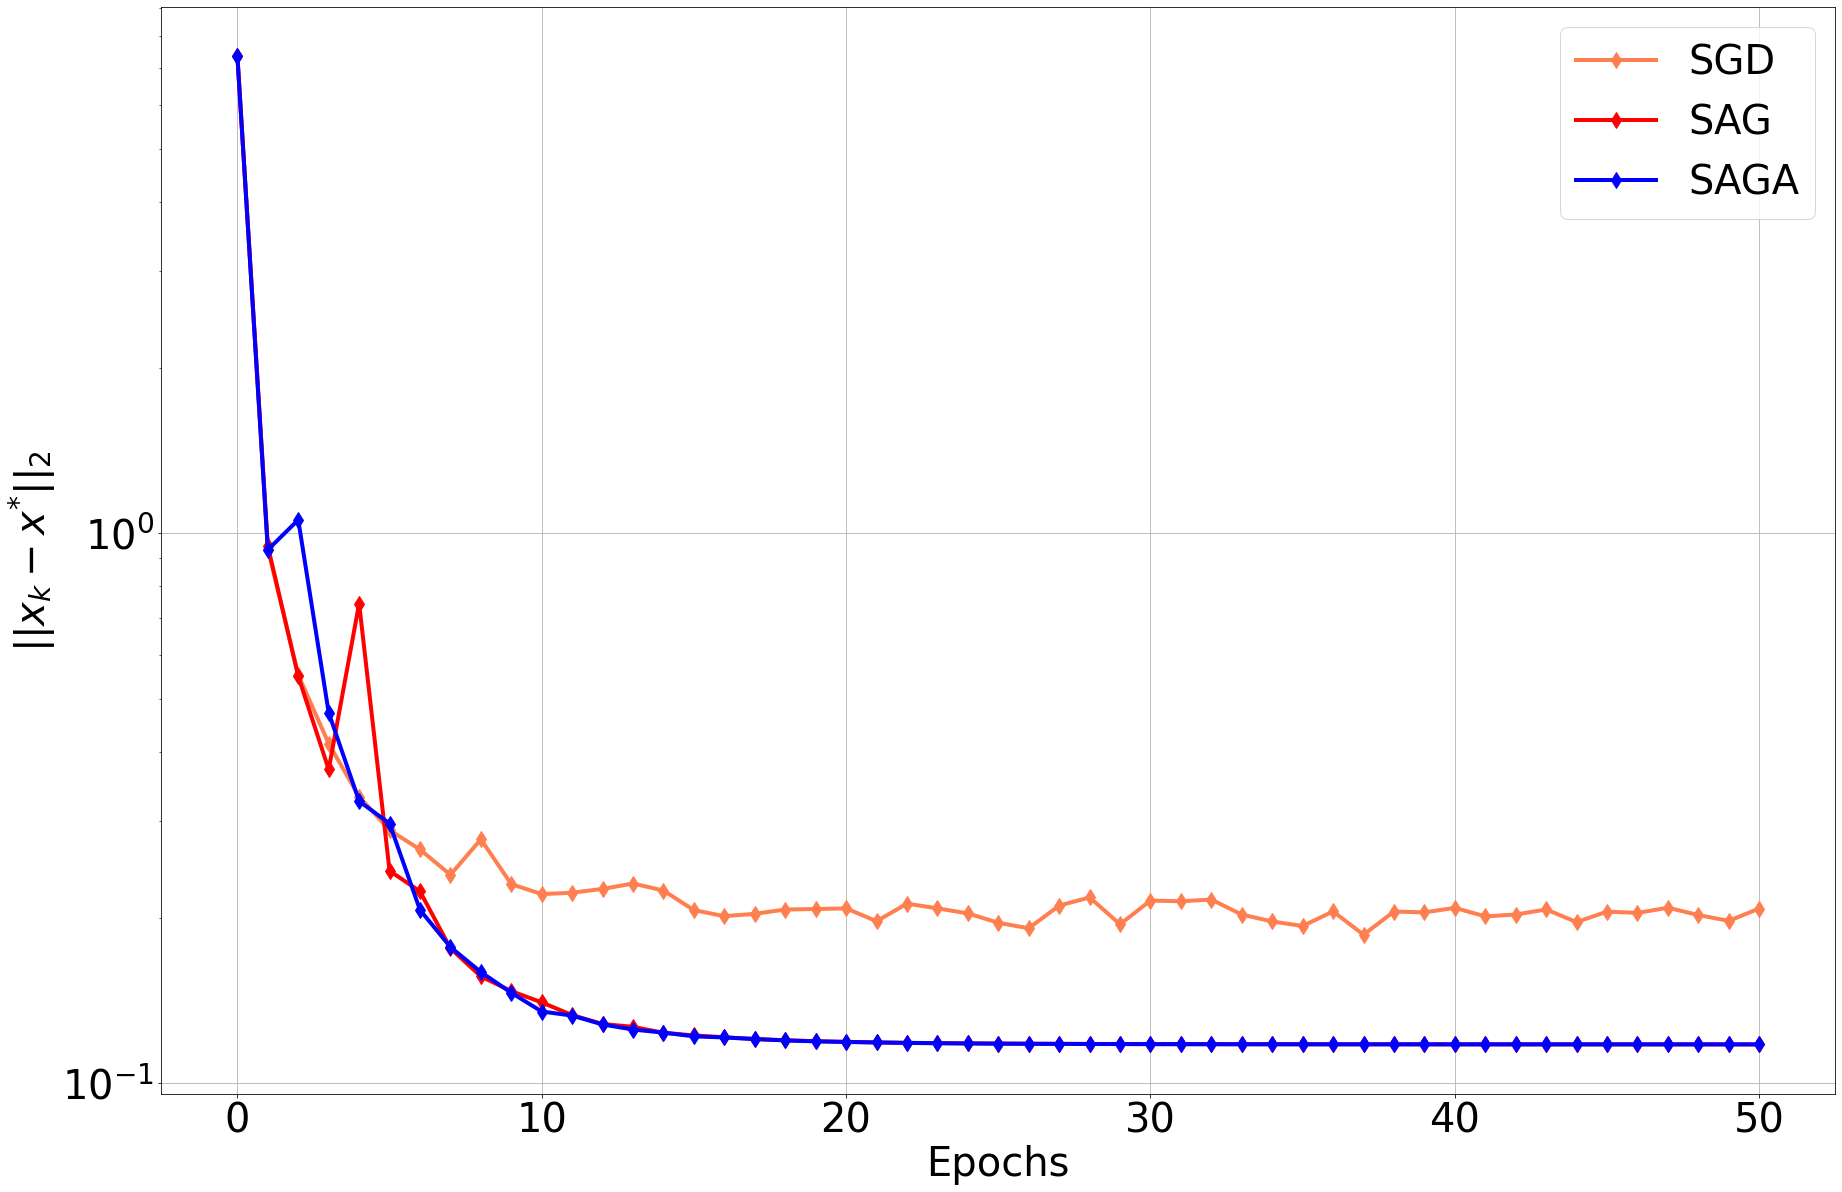

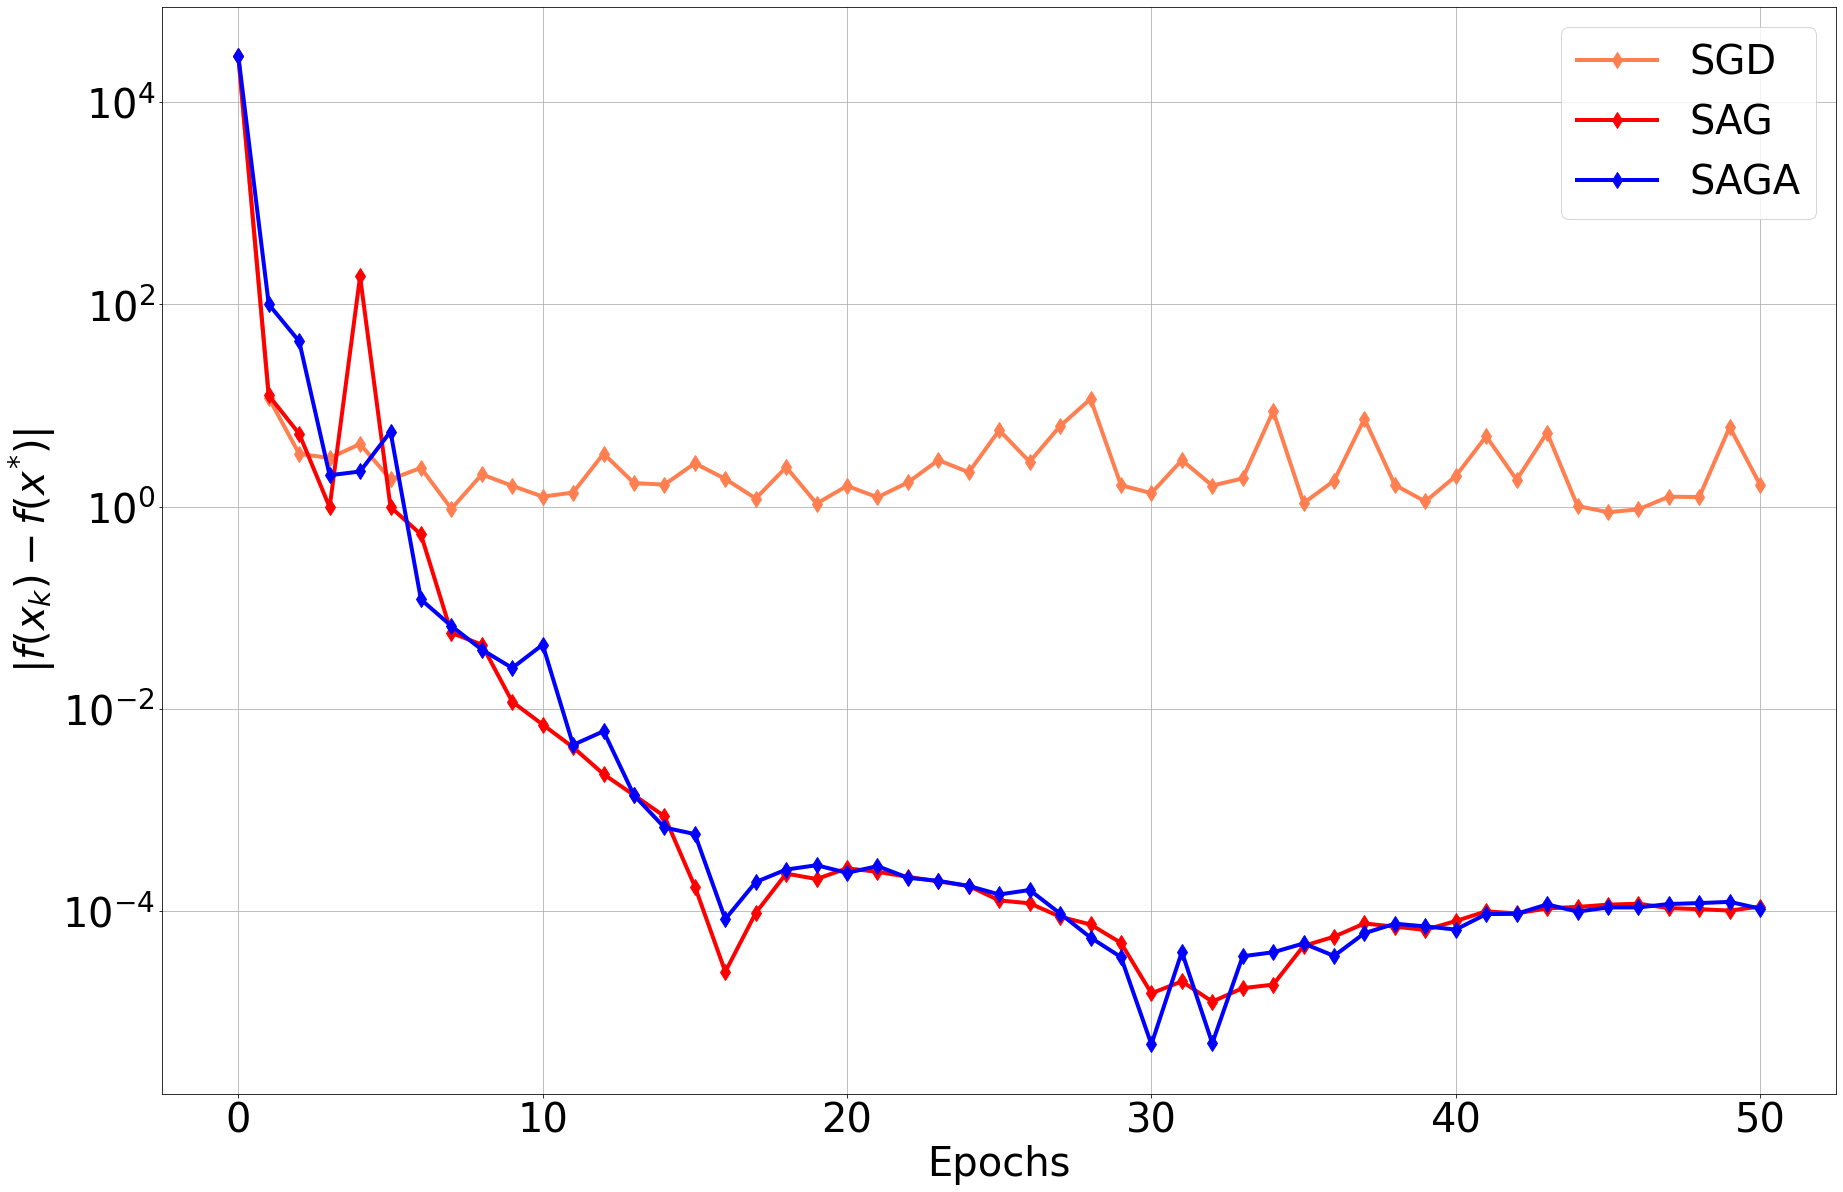

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.markersize'] = 12

plt.figure(figsize=(30,20))
plt.semilogy([l for l in recons[0].distance_from_optimal], label="SGD", color="coral", marker="d")
plt.semilogy([l for l in recons[1].distance_from_optimal], label="SAG", color="red", marker="d")
plt.semilogy([l for l in recons[2].distance_from_optimal], label="SAGA", color="blue", marker="d")
plt.ylabel("$||x_{k} - x^{*}||_{2}$",fontsize=40)
plt.xlabel("Epochs", fontsize=40)
plt.tick_params(axis='x',  labelsize=40)
plt.tick_params(axis='y',  labelsize=40)
plt.legend(loc='upper right', prop={'size': 40})
plt.grid()
plt.show()

plt.figure(figsize=(30,20))
plt.semilogy([np.abs(l-fista.objective[-1]) for l in recons[0].objective], label="SGD", color="coral", marker="d")
plt.semilogy([np.abs(l-fista.objective[-1]) for l in recons[1].objective], label="SAG", color="red", marker="d")
plt.semilogy([np.abs(l-fista.objective[-1]) for l in recons[2].objective], label="SAGA", color="blue", marker="d")
plt.ylabel("$|f(x_{k}) - f(x^{*})|$",fontsize=40)
plt.xlabel("Epochs", fontsize=40)
plt.tick_params(axis='x',  labelsize=40)
plt.tick_params(axis='y',  labelsize=40)
plt.legend(loc='upper right', prop={'size': 40})
plt.grid()
plt.show()


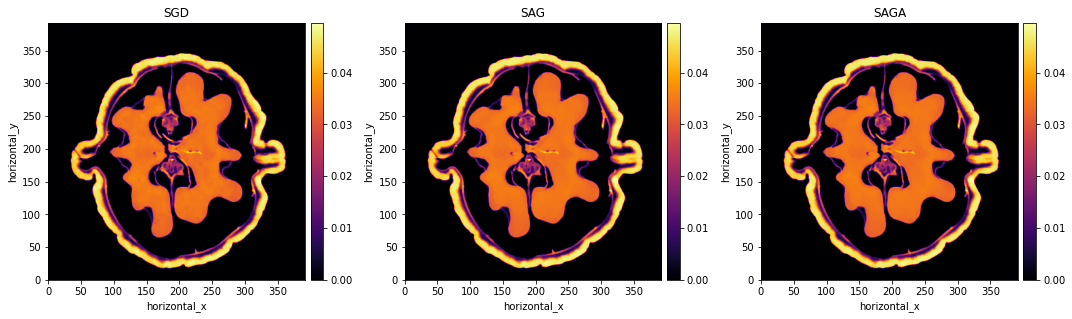

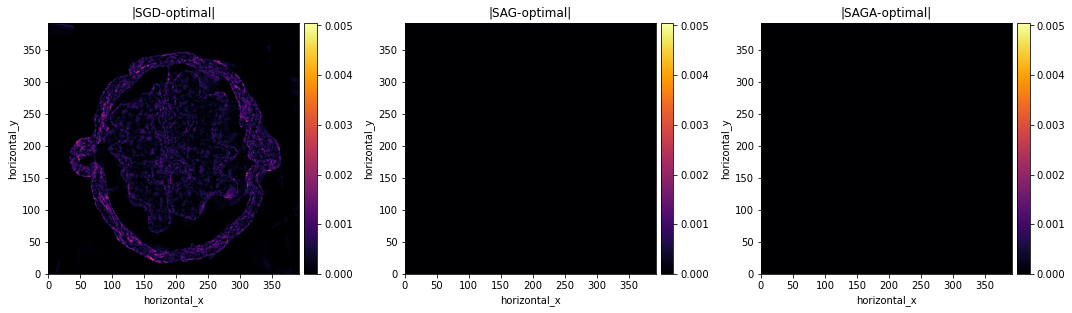

In [29]:
show2D([recons[0].solution, 
        recons[1].solution,
        recons[2].solution], title=['SGD','SAG','SAGA'],
       fix_range=True, cmap="inferno", num_cols=3)
show2D([(recons[0].solution-fista.solution).abs(), 
        (recons[1].solution-fista.solution).abs(),
        (recons[2].solution-fista.solution).abs()], 
       title=['|SGD-optimal|','|SAG-optimal|','|SAGA-optimal|'],
       fix_range=True, cmap="inferno", num_cols=3)
                                                           
